In [79]:
import sys
sys.path.append('/home/seabra/fingerprint-enhancement/')
sys.path.append('/home/seabra/fingerprint-enhancement/src')


from models.multitask_module import *
from data.enhancer_train_datamodule import EnhancerTrainDataModule

In [80]:
batch_size  = 2
data_dir   = '/storage/seabra/segmentation_study/train_data/'
data_module = EnhancerTrainDataModule(data_dir=data_dir, lat_subdir='/synth_lats_docs_mixed/', orient_subdir='/dirmap_gt_txt/', ref_subdir='basen_refs_full/', skel_subdir='ref_dist/', mask_subdir='/lat_masks_after_docs_synth_lats_docs_mixed/mask/', use_ref_mask=False,data_list='/lists/basenames/lat_list_nfiq80.txt', batch_size=batch_size)

data_module.setup()
x, orient_map, orig, bin = next(iter(data_module.train_dataloader()))


In [81]:
true_dirmap = F.interpolate(orient_map, scale_factor=8, mode="bilinear", align_corners=False)
# Target labels (B, H, W)
true_dirmap_idx = orient_map.argmax(dim=1)


# --- Preparar Inputs para Loss de Orientação ---
# Labels precisam ter dimensão de canal: (B, H, W) -> (B, 1, H, W)
true_dirmap_labels = true_dirmap_idx.unsqueeze(1)
# Usar 'true_dirmap_labels==90' como a máscara ROI: (B, H, W) -> (B, 1, H, W)
mask = (true_dirmap_labels != 90).long()

In [82]:
orient_map.shape

torch.Size([2, 91, 64, 64])

## visualize orig, skel, mask and mnt_map labels

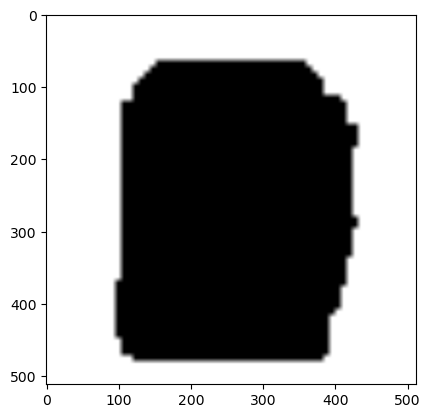

In [83]:
import matplotlib.pyplot as plt
orient_upsampled = F.interpolate(orient_map.float(), scale_factor=8, mode="bilinear", align_corners=False)
plt.imshow(orient_upsampled[0, 90, :, :], cmap = 'gray')

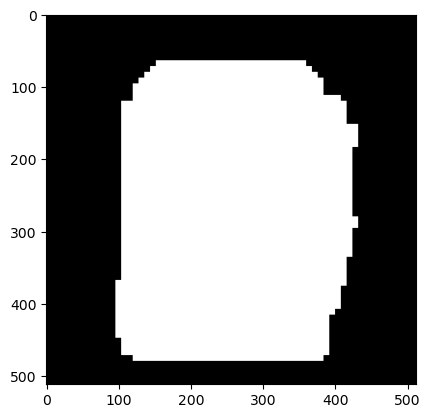

In [84]:
import matplotlib.pyplot as plt
mask_upsampled = F.interpolate(mask.float(), scale_factor=8, mode="nearest")
plt.imshow(mask_upsampled[0, 0, :, :], cmap = 'gray')

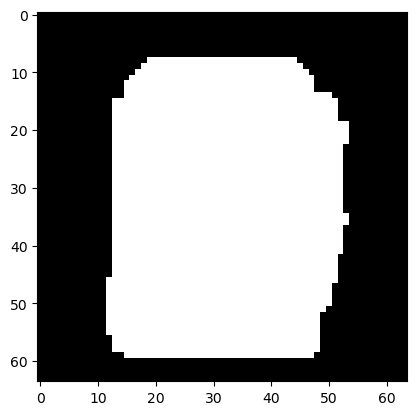

In [85]:
plt.imshow(-orient_map[0, 90, :, :], cmap = 'gray')

In [86]:
orig.shape

torch.Size([2, 1, 512, 512])

Text(0.5, 1.0, 'Orig')

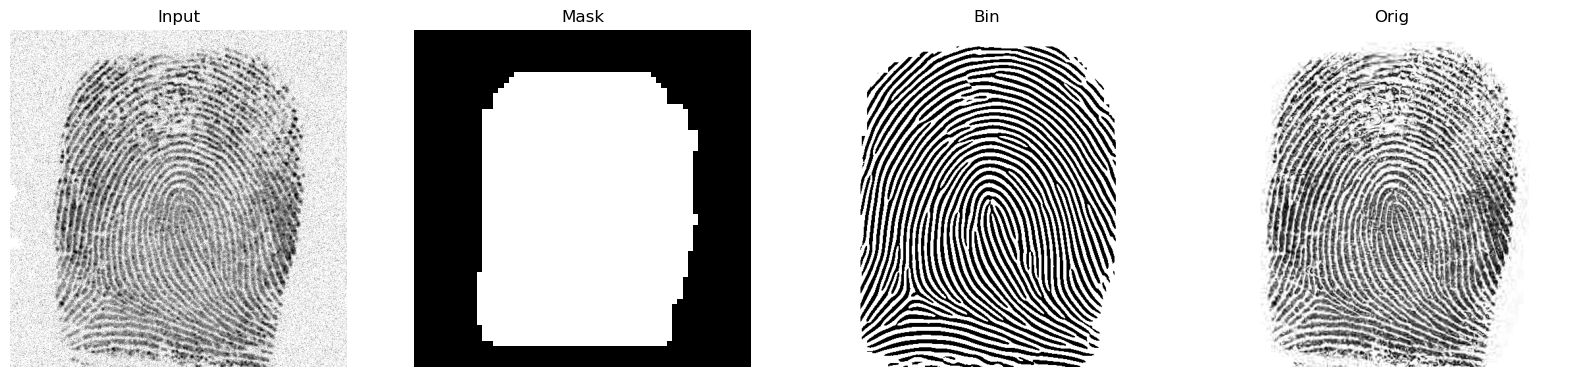

In [87]:

import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize = (20,15), nrows=1, ncols = 4)
ax[0].imshow(x[0][0], cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Input')

ax[1].imshow(mask[0, 0, :, :], cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('Mask')

ax[2].imshow(bin[0, 0, :, :], cmap = 'gray')
ax[2].axis('off')
ax[2].set_title('Bin')

ax[3].imshow(orig[0, 0, :, :], cmap = 'gray')
ax[3].axis('off')
ax[3].set_title('Orig')


Text(0.5, 1.0, 'Orig Pred')

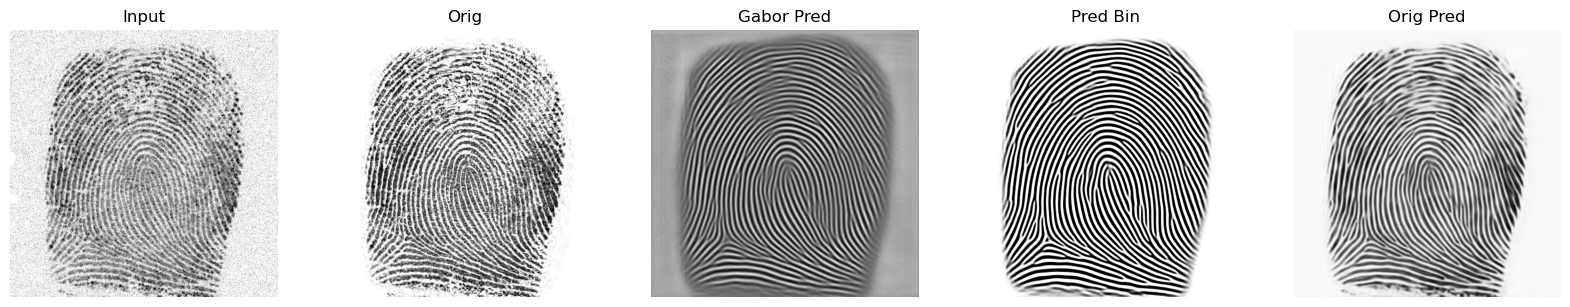

In [88]:
from data.enhancer_predict_datamodule import *
from models.components.MultiTaskDirMapEnh import *

# 1. Create the network architecture first, just like before
net = MultiTaskDirMapEnh()
model_path = '/home/seabra/fingerprint-enhancement/logs/train/runs/2025-10-24_02-00-50/checkpoints/epoch_015.ckpt'

# 2. Pass the 'net' object as an argument to the method
#    This ensures the LightningModule is instantiated correctly before loading weights.
model = EnhancerLitModule.load_from_checkpoint(
    checkpoint_path=model_path,
    net=net  # <-- THE CRUCIAL FIX
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

x     = x.to(device)
with torch.no_grad():
    model.eval()
    # enh, mask, mnts, orifield = model.forward(x)
    dirmap_pred, enh_pred = model.forward(x)

orig_pred = enh_pred[0,0,:,:].cpu().numpy()
gabor_pred = enh_pred[0,1,:,:].cpu().numpy()


def sigmoid(x):
  """
  Computes the sigmoid of x.

  Arguments:
  x -- A scalar or a NumPy array.

  Returns:
  s -- The sigmoid of x.
  """
  s = 1 / (1 + np.exp(-x))
  return s

bin = sigmoid(gabor_pred)


fig, ax = plt.subplots(figsize = (20,15), nrows=1, ncols = 5)

input_lat = x.cpu().numpy()[0,0,:,:]

ax[0].imshow(input_lat, cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Input')

ax[1].imshow(orig[0, 0, :, :], cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('Orig')

ax[2].imshow(gabor_pred, cmap = 'gray')
ax[2].axis('off')
ax[2].set_title('Gabor Pred')

ax[3].imshow(bin, cmap = 'gray')
ax[3].axis('off')
ax[3].set_title('Pred Bin')

ax[4].imshow(orig_pred, cmap = 'gray')
ax[4].axis('off')
ax[4].set_title('Orig Pred')


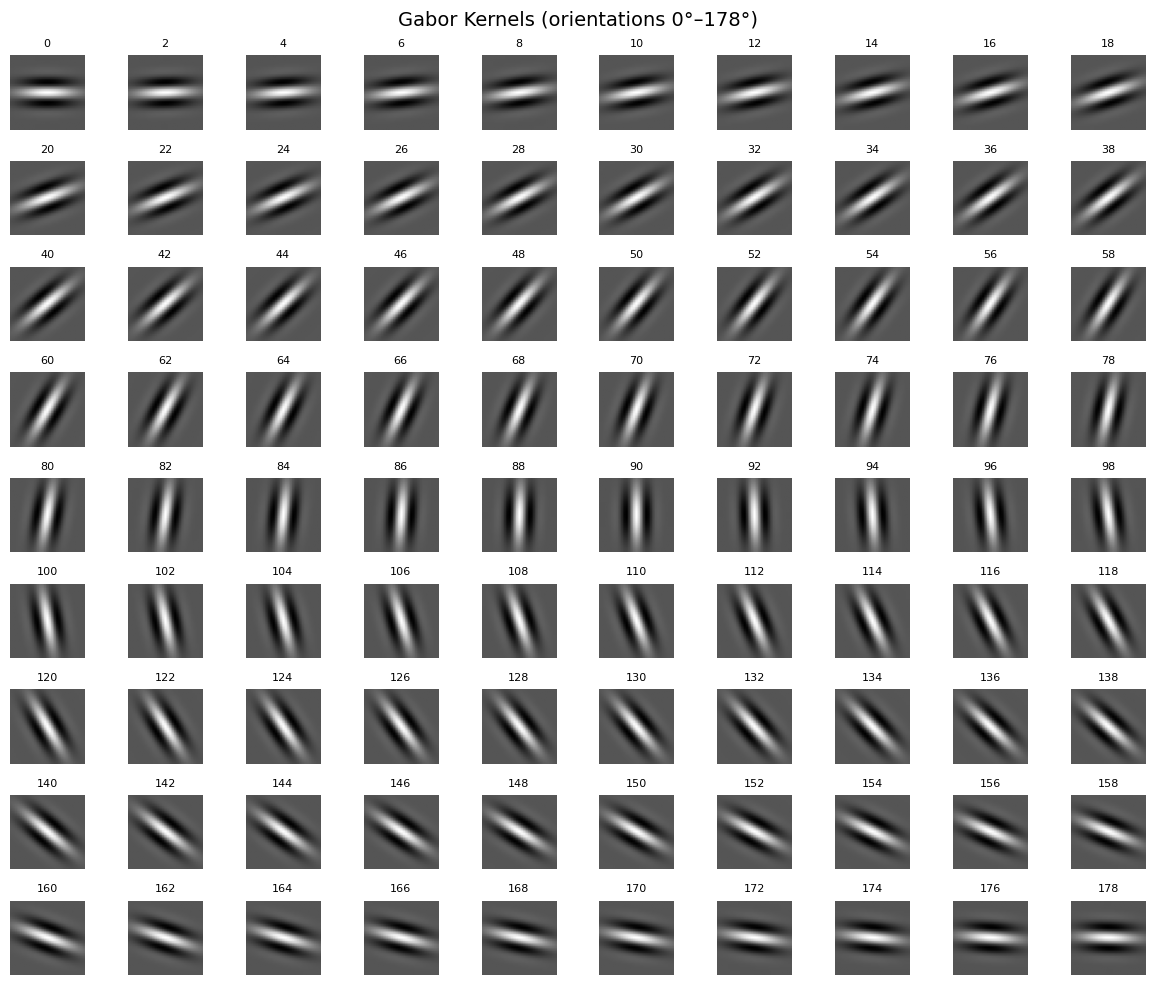

In [89]:
gabor_layer = GaborConvLayer(
            num_orientations=90, 
            ksize=31, 
            sigma=4.0, 
            lambd=10.0
        ).to(device)

# --- Visualize all Gabor kernels from your layer ---
with torch.no_grad():
    # Get the kernels from your layer
    kernels = gabor_layer.conv.weight.detach().cpu().squeeze(1)  # shape: (90, ksize, ksize)

# Normalize each kernel individually for better contrast
min_vals = kernels.view(kernels.shape[0], -1).min(dim=1, keepdim=True)[0].view(-1, 1, 1)
max_vals = kernels.view(kernels.shape[0], -1).max(dim=1, keepdim=True)[0].view(-1, 1, 1)
kernels = (kernels - min_vals) / (max_vals - min_vals + 1e-8)

# Set up grid
n_kernels = kernels.shape[0]
n_cols = 10
n_rows = (n_kernels + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    if i < n_kernels:
        ax.imshow(kernels[i], cmap='gray')
        ax.set_title(f"{i*2}", fontsize=8)
    ax.axis('off')

plt.suptitle("Gabor Kernels (orientations 0°–178°)", fontsize=14)
plt.tight_layout()
plt.show()


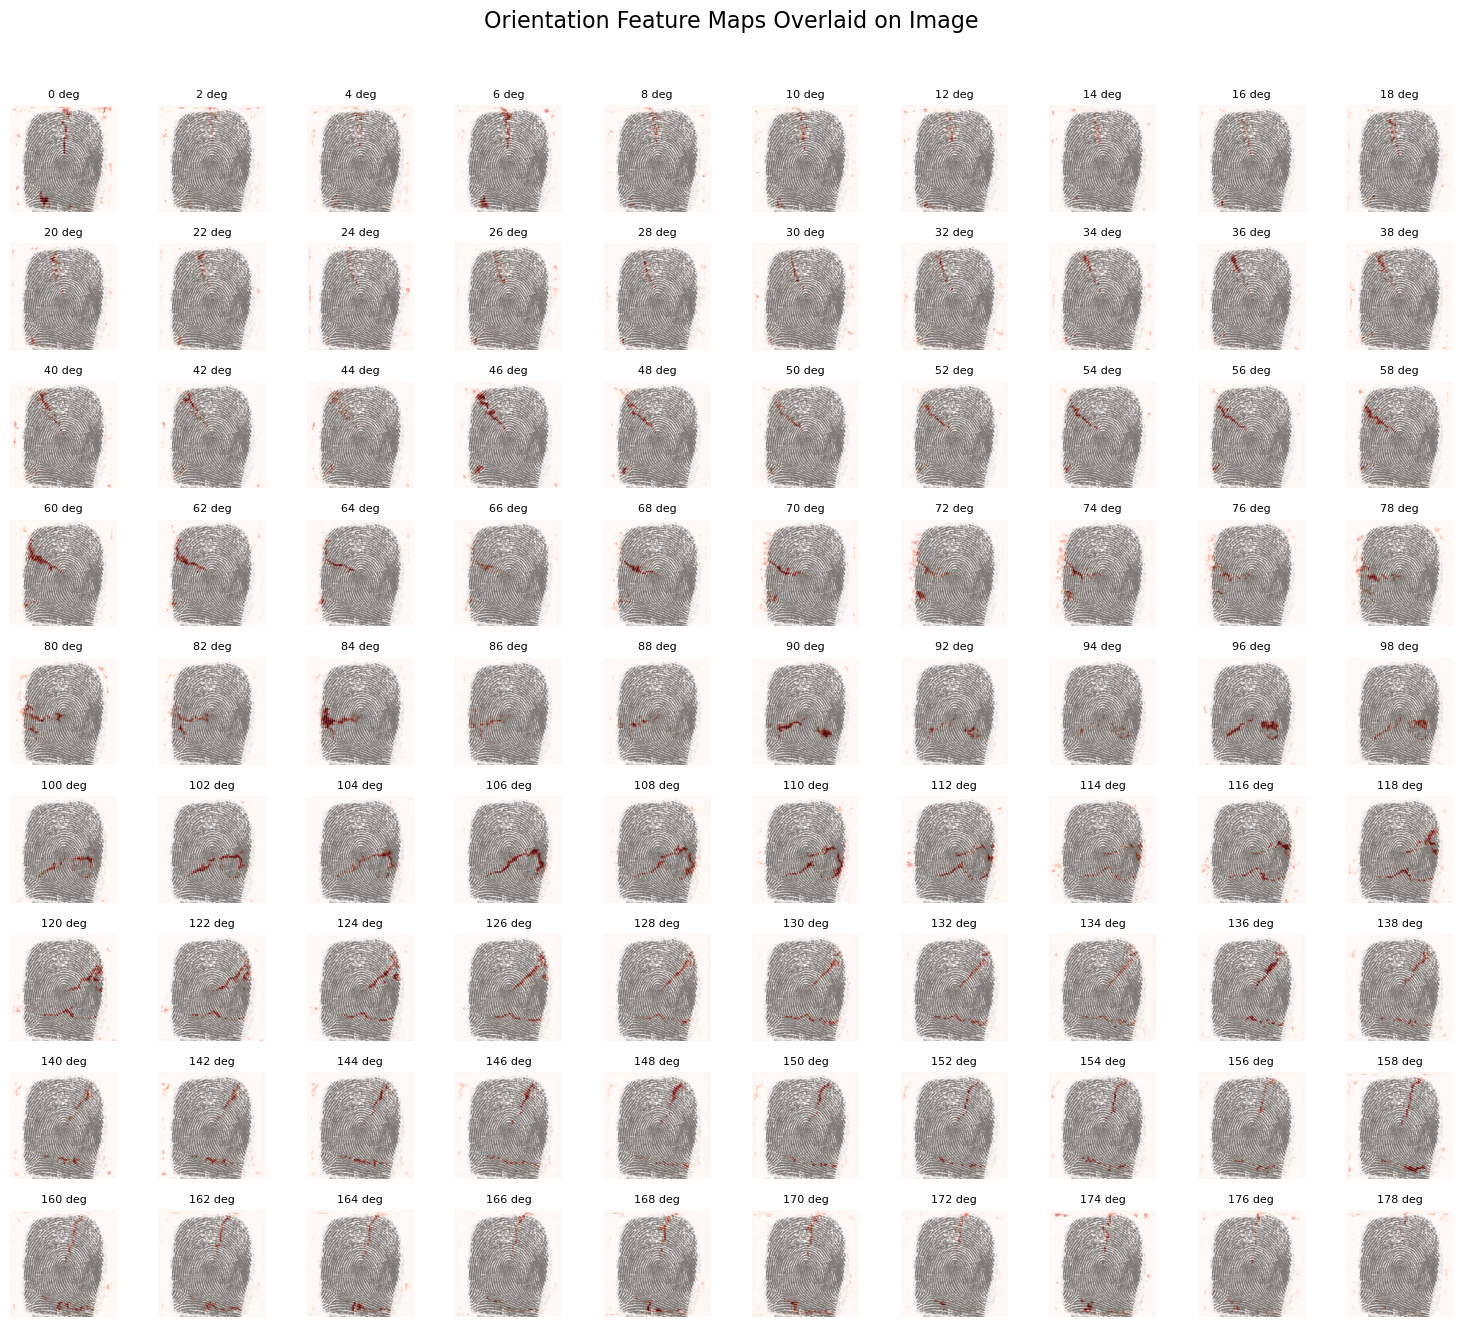

In [90]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'dirmap_pred' and 'image_lat' tensors are available
# dirmap_pred: Your model's output tensor of shape (1, num_orientations, H, W)
# image_lat: Your input image tensor of shape (1, 3, H, W)

# --- Main Logic ---

# Apply softmax to get probabilities
orientation_probs = torch.softmax(dirmap_pred, dim=1)

# Detach from the graph and move to CPU for plotting
prob_map = orientation_probs[0].detach().cpu()

# Normalize each feature map from 0 to 1 for better visualization contrast
min_vals = prob_map.view(prob_map.shape[0], -1).min(dim=1, keepdim=True)[0].view(-1, 1, 1)
max_vals = prob_map.view(prob_map.shape[0], -1).max(dim=1, keepdim=True)[0].view(-1, 1, 1)
prob_map_normalized = (prob_map - min_vals) / (max_vals - min_vals + 1e-8)

# --- Prepare the input image for display ---
# Convert the image tensor to a format suitable for Matplotlib
# 1. Select the first image from the batch
# 2. Move it to the CPU and convert to a NumPy array
# 3. Transpose dimensions from (C, H, W) to (H, W, C)
image_to_display = orig[0, 0, :, :]
# Ensure the image data is clipped to the valid display range [0, 1]
image_to_display = np.clip(image_to_display, 0, 1)

# --- Plotting Section ---
n_filters = prob_map_normalized.shape[0]
n_cols = 10
n_rows = (n_filters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 1.5))
for i, ax in enumerate(axes.flat):
    if i < n_filters:
        # 1. Display the original image as the background
        ax.imshow(image_to_display, cmap='gray')
        
        # 2. Overlay the feature map with transparency.
        #    'jet' or 'hot' colormaps often work well for highlighting activations.
        ax.imshow(prob_map_normalized[i], cmap='Reds', alpha=0.5)
        
        ax.set_title(f"{i*2} deg", fontsize=8)
    
    # Hide the axes for a cleaner look
    ax.axis('off')

plt.suptitle("Orientation Feature Maps Overlaid on Image", fontsize=16)
# Adjust layout to prevent title overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

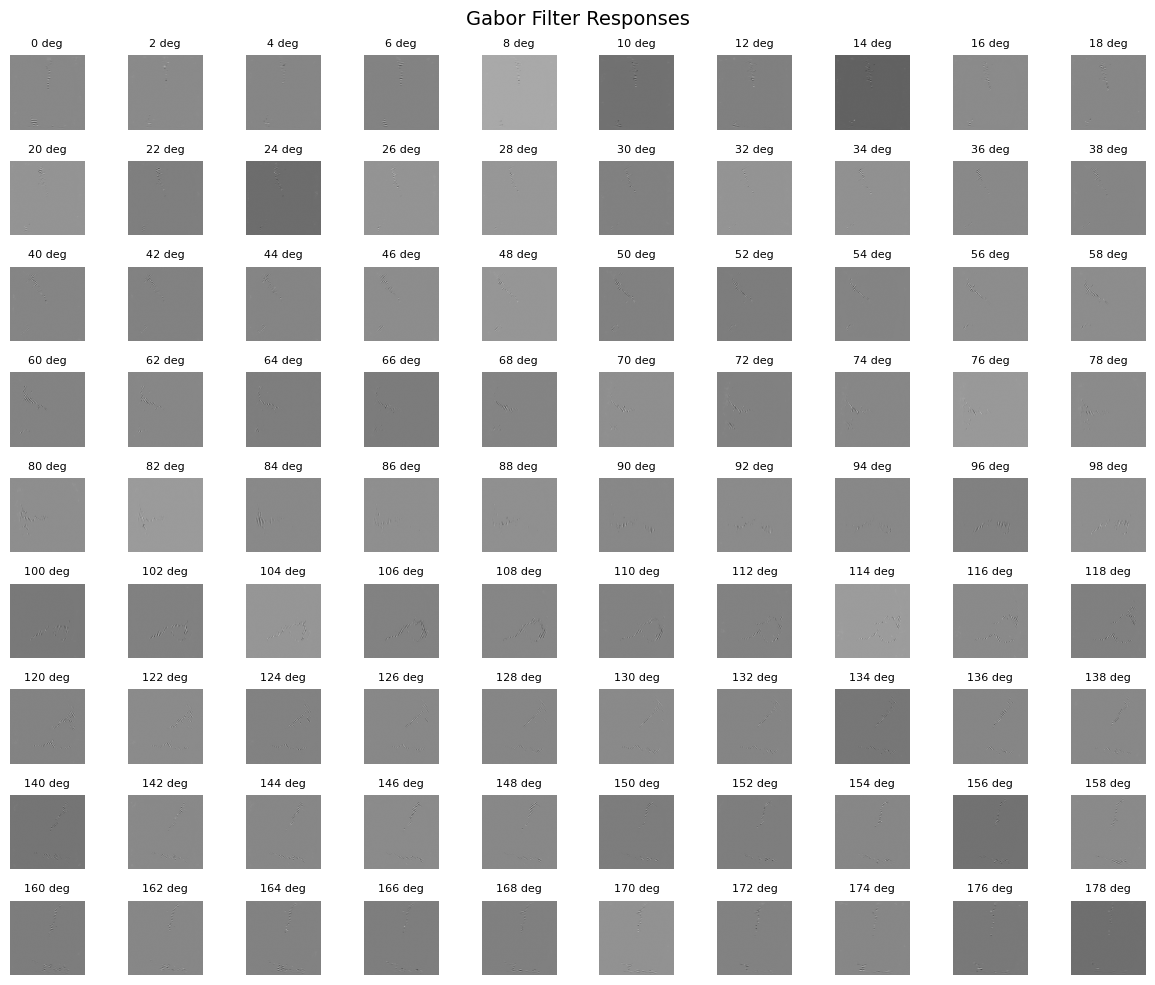

In [91]:


# --- Step 2: Get Gabor filter responses ---
# gabor_responses shape: (B, 90, H, W)
gabor_responses = gabor_layer(x)

# --- Step 3: Weight Gabor responses by orientation probabilities ---
# Element-wise multiplication
weighted_responses = gabor_responses * orientation_probs

import matplotlib.pyplot as plt

# Example: visualize Gabor responses for one sample in the batch
# gabor_responses shape: (B, 90, H, W)
idx = 0  # which sample in the batch to visualize
responses = weighted_responses[idx].detach().cpu()  # (90, H, W)

# Normalize each response for better visualization
# Normalize each response for better visualization
min_vals = responses.view(responses.shape[0], -1).min(dim=1, keepdim=True)[0].view(-1, 1, 1)
max_vals = responses.view(responses.shape[0], -1).max(dim=1, keepdim=True)[0].view(-1, 1, 1)
responses = (responses - min_vals) / (max_vals - min_vals + 1e-8)

# Plot a grid of responses
n_filters = responses.shape[0]
n_cols = 10
n_rows = (n_filters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    if i < n_filters:
        ax.imshow(responses[i], cmap='gray')
        ax.set_title(f"{i*2} deg", fontsize=8)
    ax.axis('off')

plt.suptitle("Gabor Filter Responses", fontsize=14)
plt.tight_layout()
plt.show()



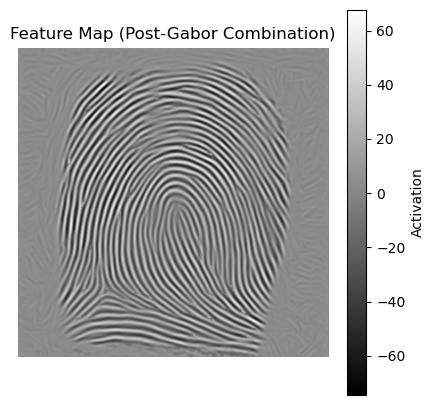

In [92]:


# --- Step 4: Sum the weighted responses to get a single feature map ---
# Sum across the 90 channels
# combined_feature_map shape: (B, 1, H, W)
combined_feature_map = torch.sum(weighted_responses, dim=1, keepdim=True)

combined_feature_map_np = combined_feature_map[0,0,:,:].detach().cpu().numpy()
# Display with matplotlib
plt.figure(figsize=(5, 5))
plt.imshow(combined_feature_map_np, cmap='gray')  # or 'gray' for grayscale visualization
plt.title(f"Feature Map (Post-Gabor Combination)")
plt.axis('off')
plt.colorbar(label='Activation')
plt.show()


In [93]:

# --- Step 5: Feed the enhanced map to the segmentation network ---
out_enh = self.enhancer_net(combined_feature_map)

NameError: name 'self' is not defined

In [ ]:
class MyWeightedL1Loss(nn.L1Loss):
    def __init__(self, reduction='none'):
        super(MyWeightedL1Loss, self).__init__(reduction=reduction)

    def forward(self, input, target, pixel_weight):
        pixel_mae = super(MyWeightedL1Loss, self).forward(input, target)
        loss = pixel_mae * pixel_weight
        print(loss.shape)
        return loss.sum()/(loss.size(0)) # mean per-image loss (not per-pixel or per-batch).


loss_map           = torch.nn.functional.binary_cross_entropy_with_logits(enh[:,1,:,:], bin, reduction = 'none')
# minutia_weight_map =  extract_mcc_cpu(mnts_label, img.shape, 12, 5.0)
# minutia_weight_map.shape
# minutia_weight_map = (minutia_weight_map - torch.min(minutia_weight_map)) / (torch.max(minutia_weight_map) - torch.min(minutia_weight_map))

criterion = MyWeightedL1Loss()

simple_loss   = torch.mean(loss_map)
weighted_loss = torch.mean(loss_map * skel)

# old_loss = criterion(enh[:,1,:,:], skel, skel)

# mean_mask_loss = torch.mean(torch.sum(loss_map * skel, dim=(1,2)) / (torch.sum(skel, dim=(1,2)) + 1e-7) )


print("Simple loss: ", simple_loss)
print("Weighted loss: ", weighted_loss)

fig, ax = plt.subplots(figsize = (10,4), nrows = 1, ncols = 3)
ax[0].imshow((loss_map)[0], cmap = 'gray')
ax[0].axis('off')
ax[0].set_title("Loss Normal")
ax[1].imshow(skel[0], cmap = 'gray')
ax[1].axis('off')
ax[1].set_title("Skeleton Distance Map")
ax[2].imshow((loss_map * skel)[0], cmap = 'gray')
ax[2].axis('off')
ax[2].set_title("Skeleton Distance Weighted Loss")


fig.tight_layout()
plt.show()

TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
mean_mask_loss.shape

NameError: name 'mean_mask_loss' is not defined

In [ ]:
loss_map.shape

torch.Size([2, 512, 512])

In [ ]:
enh.shape

torch.Size([2, 1, 512, 512])

In [ ]:
mnt_map.shape

torch.Size([2, 512, 512])